# Lasso Regression for NBA Veterans

by: Tristan Dewing and Adhvaith Vijay

## Importing Packages

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

In [85]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [86]:
import sklearn.preprocessing, sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn_pandas import DataFrameMapper

In [87]:
np.random.seed(4242)

## Cleaning the Dataset (Adhvaith)

We first take the dataset of NBA players' statistics and then subset veteran players with more than 1 year of experience as well as the set of columns that will best predict Salary, which are: `FG`, `FTA`, `AST`, `TRB`, `PTS`, `BLK`, `years_of_exp`, `Pos`, `SalStartYr`, `Player`. We will also remove rows with outliers in `Salary`.

In [88]:
adv_df = pd.read_csv('adv_df.csv')

In [89]:
adv_df.tail()

,Unnamed: 0,Player,StartYr,EndYr,SalStartYr,SalEndYr,Salary,SalaryInfl,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,years_of_exp,salary_cap,salary_cap_adjusted,Per_of_Salary_Cap
6217,16844,Delon Wright,2019,2020,2020,2021,9000000.0,8526316.0,PG,27,DAL,73,5.0,21.5,2.6,5.6,0.462,0.6,1.7,0.370,2.0,3.9,0.504,0.519,1.1,1.4,0.770,1.0,2.9,3.8,3.3,1.2,0.3,1.0,1.3,6.9,5,109140000,NaN,0.082463
6218,16846,Thaddeus Young,2019,2020,2020,2021,13545000.0,14190000.0,PF,31,CHI,64,16.0,24.9,4.2,9.4,0.448,1.2,3.5,0.356,3.0,5.9,0.501,0.513,0.7,1.1,0.583,1.5,3.5,4.9,1.8,1.4,0.4,1.6,2.1,10.3,13,109140000,NaN,0.124107
6219,16847,Trae Young,2019,2020,2020,2021,6571800.0,8326471.0,PG,21,ATL,60,60.0,35.3,9.1,20.8,0.437,3.4,9.5,0.361,5.7,11.4,0.501,0.519,8.0,9.3,0.860,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6,2,109140000,NaN,0.060214
6220,16848,Cody Zeller,2019,2020,2020,2021,15415730.0,0.0,C,27,CHO,58,39.0,23.1,4.3,8.3,0.524,0.3,1.3,0.240,4.0,7.0,0.577,0.543,2.1,3.1,0.682,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1,7,109140000,NaN,0.141247
6221,16851,Ivica Zubac,2019,2020,2020,2021,7000000.0,7518518.0,C,22,LAC,72,70.0,18.4,3.3,5.3,0.613,0.0,0.0,0.000,3.3,5.3,0.616,0.613,1.7,2.3,0.747,2.7,4.8,7.5,1.1,0.2,0.9,0.8,2.3,8.3,4,109140000,NaN,0.064138


In [90]:
len(adv_df['Player'].unique())

1306

In [91]:
adv_df.drop(adv_df.columns[0], axis = 1, inplace = True)

In [92]:
christine_subset = adv_df[['FG', 'FTA', 'AST', 'TRB', 'PTS', 'BLK', 'years_of_exp','Salary','Pos','SalStartYr','Player']]

In [93]:
v1 = christine_subset.groupby(['Player','SalStartYr','FG', 'FTA', 'AST', 'TRB', 'PTS', 'BLK', 'years_of_exp','Pos']).agg({'Salary':sum}).reset_index()

In [94]:
v1.head()

,Player,SalStartYr,FG,FTA,AST,TRB,PTS,BLK,years_of_exp,Pos,Salary
0,Aaron Brooks,2008,1.8,1.0,1.7,1.1,5.2,0.1,1,PG,1045560.0
1,Aaron Brooks,2009,4.0,2.2,3.0,2.0,11.2,0.1,2,PG,1118520.0
2,Aaron Brooks,2010,7.0,3.6,5.3,2.6,19.6,0.2,3,PG,2016692.0
3,Aaron Brooks,2013,2.7,1.0,2.2,1.5,7.1,0.2,5,PG,1027424.0
4,Aaron Brooks,2014,3.2,1.3,3.2,1.9,9.0,0.2,6,PG,915243.0


In [95]:
v1['index'] = v1.index

In [96]:
def get_year_before(val):
    experience = v1.loc[v1['index'] == val, 'years_of_exp'].values[0]
    if experience == 1:
        return v1.loc[v1['index'] == val, 'Salary'].values[0]
    else:
        return v1.loc[v1['index'] == (val - 1), 'Salary'].values[0]

In [97]:
v1['salary_before'] = v1['index'].apply(get_year_before)

In [98]:
v1.drop(columns = 'index', inplace = True)

In [99]:
v1.head()

,Player,SalStartYr,FG,FTA,AST,TRB,PTS,BLK,years_of_exp,Pos,Salary,salary_before
0,Aaron Brooks,2008,1.8,1.0,1.7,1.1,5.2,0.1,1,PG,1045560.0,1045560.0
1,Aaron Brooks,2009,4.0,2.2,3.0,2.0,11.2,0.1,2,PG,1118520.0,1045560.0
2,Aaron Brooks,2010,7.0,3.6,5.3,2.6,19.6,0.2,3,PG,2016692.0,1118520.0
3,Aaron Brooks,2013,2.7,1.0,2.2,1.5,7.1,0.2,5,PG,1027424.0,2016692.0
4,Aaron Brooks,2014,3.2,1.3,3.2,1.9,9.0,0.2,6,PG,915243.0,1027424.0


In [100]:
v1.index = v1['Player']

In [101]:
v1 = v1[v1['years_of_exp'] != 1]

In [102]:
v1.head()

,Player,SalStartYr,FG,FTA,AST,TRB,PTS,BLK,years_of_exp,Pos,Salary,salary_before
Player,,,,,,,,,,,,
Aaron Brooks,Aaron Brooks,2009,4.0,2.2,3.0,2.0,11.2,0.1,2,PG,1118520.0,1045560.0
Aaron Brooks,Aaron Brooks,2010,7.0,3.6,5.3,2.6,19.6,0.2,3,PG,2016692.0,1118520.0
Aaron Brooks,Aaron Brooks,2013,2.7,1.0,2.2,1.5,7.1,0.2,5,PG,1027424.0,2016692.0
Aaron Brooks,Aaron Brooks,2014,3.2,1.3,3.2,1.9,9.0,0.2,6,PG,915243.0,1027424.0
Aaron Brooks,Aaron Brooks,2015,4.2,2.1,3.2,2.0,11.6,0.2,7,PG,2250000.0,915243.0


In [103]:
christine_subset = v1

In [104]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
christine_subset['SalStartYr'] = le.fit_transform(christine_subset['SalStartYr'])
christine_subset['Player'] = le.fit_transform(christine_subset['Player'])
christine_subset['Pos'] = le.fit_transform(christine_subset['Pos'])


## Eliminating Outliers in Salary (Adhvaith)

In [105]:
#first quartile
q1 = christine_subset['Salary'].quantile(.25)

In [106]:
#first quartile
q3 = christine_subset['Salary'].quantile(.75)

In [107]:
#interquartile range
iqr = q3 - q1
iqr

7278033.0

In [108]:
#lower limit for outliers, lower than 0 so no need to account for
lower = q1 - 1.5 * iqr
lower

-8929249.5

In [109]:
#upper limit for outliers
upper = q3 + 1.5 * iqr
upper

20182882.5

In [110]:
christine_subset.shape

(5343, 12)

In [111]:
outliers = christine_subset[christine_subset['Salary'] >= upper]
len(outliers)

240

In [112]:
christine_subset = christine_subset[christine_subset['Salary'] < upper]

## Forming Clusters via Elbow Method (Adhvaith)

Next, we will form clusters within the cleaned dataset based on `Salary` and add them as a new column `Cluster`.

In [113]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as pl

In [114]:
to_elbow = christine_subset.drop(columns = ['salary_before'], axis = 1)

In [115]:
distortions = []
inertias = []

K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(to_elbow)
    kmeanModel.fit(to_elbow)
 
    distortions.append(sum(np.min(cdist(to_elbow, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / to_elbow.shape[0])
    
    inertias.append(kmeanModel.inertia_)

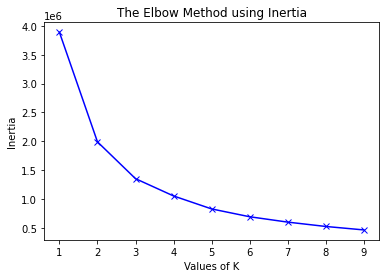

In [116]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [117]:
kmeans=KMeans(n_clusters=3,random_state=1)

In [118]:
kmeans.fit(to_elbow)

KMeans(n_clusters=3, random_state=1)

In [119]:
to_elbow['Cluster'] = kmeans.labels_

In [120]:
to_elbow['Cluster'].unique()

array([1, 0, 2], dtype=int32)

In [121]:
to_elbow.shape

(5103, 12)

In [122]:
christine_subset['Cluster'] = to_elbow['Cluster']

In [123]:
christine_subset.head()

,Player,SalStartYr,FG,FTA,AST,TRB,PTS,BLK,years_of_exp,Pos,Salary,salary_before,Cluster
Player,,,,,,,,,,,,,
Aaron Brooks,0,8,4.0,2.2,3.0,2.0,11.2,0.1,2,5,1118520.0,1045560.0,1
Aaron Brooks,0,9,7.0,3.6,5.3,2.6,19.6,0.2,3,5,2016692.0,1118520.0,1
Aaron Brooks,0,12,2.7,1.0,2.2,1.5,7.1,0.2,5,5,1027424.0,2016692.0,1
Aaron Brooks,0,13,3.2,1.3,3.2,1.9,9.0,0.2,6,5,915243.0,1027424.0,1
Aaron Brooks,0,14,4.2,2.1,3.2,2.0,11.6,0.2,7,5,2250000.0,915243.0,1


## Lasso Regression

We will now fit a lasso regression model to the dataset to predict `Salary`. The goal is to fit a lasso regression model that produces a high R^2 score and a low RMSE. We attempted to fit a model to all three clusters of the dataset, but here for brevity we have fitted the model to one cluster, which can be adjusted in the code. Part of the lasso regression process is determining the optimal value for the hyperparameter alpha, or lamda, which determines the penalty for the lasso regression model. The process we use to determine alpha/lamda is inspired by Jan Kirenz's article "Lasso Regression with Python": https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/

### Inspired by: https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/

In [124]:
c0 = christine_subset[christine_subset["Cluster"] == 0] # Cluster 0
c1 = christine_subset[christine_subset["Cluster"] == 1] # Cluster 1
c2 = christine_subset[christine_subset["Cluster"] == 2] # Cluster 2

### Switch between Clusters 0 (c0), 1 (c1), and 2 (c2) Here!

In [125]:
# Default: Cluster 0 (c0)
X = c0.drop(columns = ["Salary", "Cluster"])
y = c0["Salary"]

### Scaling and Train-Test Split

In [126]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10)

print("X.shape:      ", X.shape)
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("")
print("y.shape:      ", y.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape: ", y_test.shape)
print("")

X.shape:       (1435, 11)
X_train.shape: (1148, 11)
X_test.shape:  (287, 11)

y.shape:       (1435,)
y_train.shape: (1148,)
y_test.shape:  (287,)



In [127]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha = 0.001, max_iter = 1e4) # Note: I had to increase parameter max_iter for Lasso model to converge
reg.fit(X_train, y_train)
reg.score(X_test, y_test) # Initial R^2 Scores on Test Set

0.20333373143333

In [128]:
# Initial R^2 Scores on Training and Test Sets:
print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train))
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test))

Lasso Regression: R^2 score on training set 0.1697249403943537
Lasso Regression: R^2 score on test set 0.20333373143333


In [129]:
# Initial RMSE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, reg.predict(X_test), squared = False)

1526392.8557464809

### Testing to Find Best Alpha (or Lamda) Value

Here we will try plugging in an assortment of alpha/lamda values to approximate what the optimal value will be or what it will be close to.

In [130]:
lamdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

# prepare data for enumerate
coeff_l = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

In [131]:
# enumerate through lamdas with index and i
for ind, i in enumerate(lamdas):    
    reg = Lasso(alpha = i, max_iter = 1e4)
    reg.fit(X_train, y_train)

    coeff_l[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

As the plot below shows, R^2 for both the training and test sets are the same for all the given alpha/lamda values, which hints that the value can be anything. However, we will use cross-validation to confirm this. 

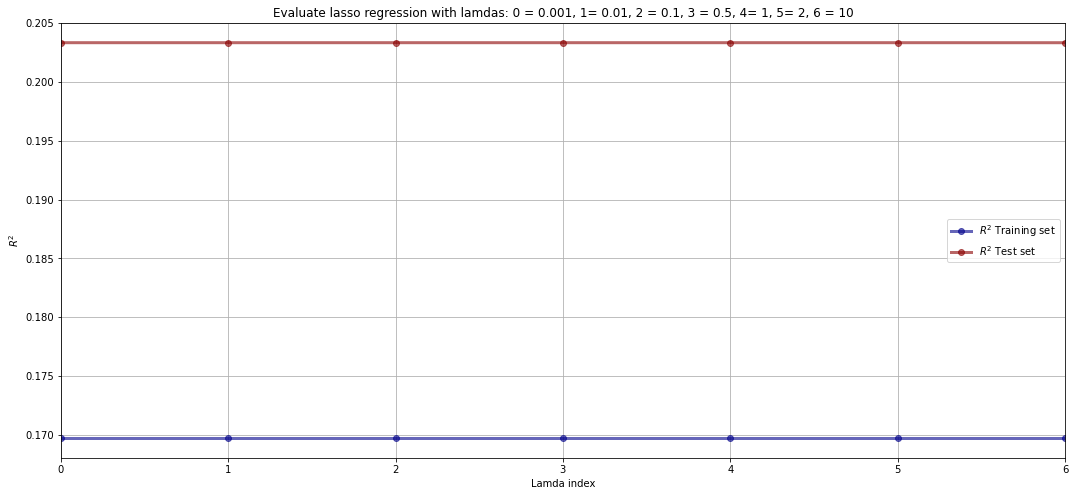

In [132]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

In [133]:
df_lamda = pd.DataFrame(test_r_squared, columns=['R_squared'])
df_lamda['lamda'] = (lamdas)
# returns the index of the row where column has maximum value.
df_lamda.loc[df_lamda['R_squared'].idxmax()]

R_squared    0.203334
lamda        0.001000
Name: 0, dtype: float64

In [134]:
print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train))
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test))

Lasso Regression: R^2 score on training set 0.16972493440944048
Lasso Regression: R^2 score on test set 0.2033318737736728


In [135]:
mean_squared_error(y_test, reg.predict(X_test), squared = False)

1526394.6353604097

### Cross-Validation for Best Alpha (or Lamda) Value

In [136]:
l_min = 0.001
l_max = 10
l_num = 100
lambdas = np.linspace(l_min, l_max, l_num)
print(lambdas)

train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i, max_iter = 1e4)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=5, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

[1.000e-03 1.020e-01 2.030e-01 3.040e-01 4.050e-01 5.060e-01 6.070e-01
 7.080e-01 8.090e-01 9.100e-01 1.011e+00 1.112e+00 1.213e+00 1.314e+00
 1.415e+00 1.516e+00 1.617e+00 1.718e+00 1.819e+00 1.920e+00 2.021e+00
 2.122e+00 2.223e+00 2.324e+00 2.425e+00 2.526e+00 2.627e+00 2.728e+00
 2.829e+00 2.930e+00 3.031e+00 3.132e+00 3.233e+00 3.334e+00 3.435e+00
 3.536e+00 3.637e+00 3.738e+00 3.839e+00 3.940e+00 4.041e+00 4.142e+00
 4.243e+00 4.344e+00 4.445e+00 4.546e+00 4.647e+00 4.748e+00 4.849e+00
 4.950e+00 5.051e+00 5.152e+00 5.253e+00 5.354e+00 5.455e+00 5.556e+00
 5.657e+00 5.758e+00 5.859e+00 5.960e+00 6.061e+00 6.162e+00 6.263e+00
 6.364e+00 6.465e+00 6.566e+00 6.667e+00 6.768e+00 6.869e+00 6.970e+00
 7.071e+00 7.172e+00 7.273e+00 7.374e+00 7.475e+00 7.576e+00 7.677e+00
 7.778e+00 7.879e+00 7.980e+00 8.081e+00 8.182e+00 8.283e+00 8.384e+00
 8.485e+00 8.586e+00 8.687e+00 8.788e+00 8.889e+00 8.990e+00 9.091e+00
 9.192e+00 9.293e+00 9.394e+00 9.495e+00 9.596e+00 9.697e+00 9.798e+00
 9.899

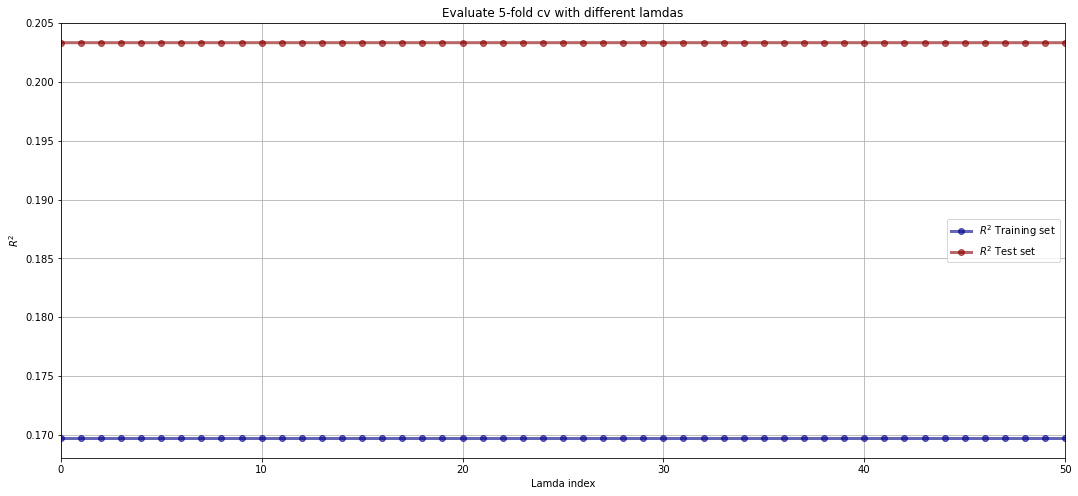

In [137]:
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 50)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

### Best Lasso Regression Model for Veterans

In this section, the R^2 value, model coefficients, and RMSE of the best fit lasso regression model with the optimal alpha/lamda value will be computed.

In [138]:
df_lam = pd.DataFrame(test_r_squared, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    0.203334
lambda       0.001000
Name: 0, dtype: float64

In [139]:
# Coefficients of best model
reg_best = Lasso(alpha = 0.001, max_iter = 1e4)
reg_best.fit(X_train, y_train)
reg_best.coef_

array([ 29585.16652677, 148732.02547947, -16378.85658468,  35700.55214179,
       118462.18621866,  95078.85473676, 203979.35130458, 137644.76939315,
       -41585.53171881,  57079.46852255, 555727.12793222])

In [140]:
reg_best.score(X_test, y_test)

0.20333373143333

In [141]:
mean_squared_error(y_test, reg_best.predict(X_test), squared = False)

1526392.8557464809

### Data Visualizations of Best Lasso Model

Lastly, there are two data visualizations below: the first is a scatterplot comparing the predicted `Salary` v.s. the actual `Salary`, and the second is a plot showing the values of the coefficients of each predictor in the lasso regression model which indicates which variables are best at predicting `Salary`. In the first plot, the points should ideally fall close to or on the black dashed line, which represents a one-to-one relationship between the predicted and actual `Salary`. For the second plot, the blue dashed line at the x-axis represents where coefficients equal zero and thus make the predictor variable insignificant.

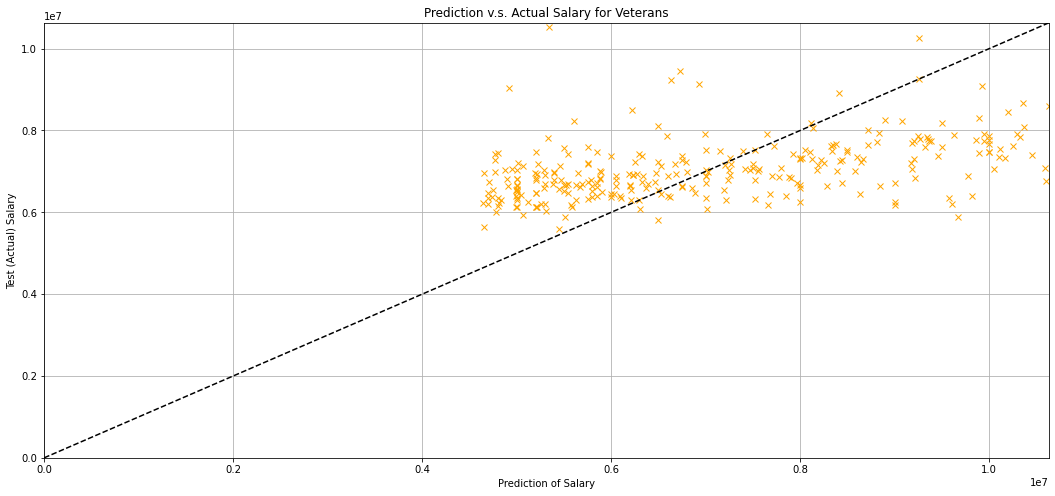

In [142]:
# Scatterplot of Predicted v.s. Actual Salary of Veterans

y_pred = reg_best.predict(X_test)

plt.figure(figsize=(18, 8))
plt.plot(y_test, y_pred, "x", color = "orange")
lims = [0, max(np.max(y_test), np.max(y_pred))]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linestyle = 'dashed', color = 'black')
plt.ylabel("Test (Actual) Salary")
plt.xlabel("Prediction of Salary")
plt.title("Prediction v.s. Actual Salary for Veterans")
plt.grid()
plt.show()

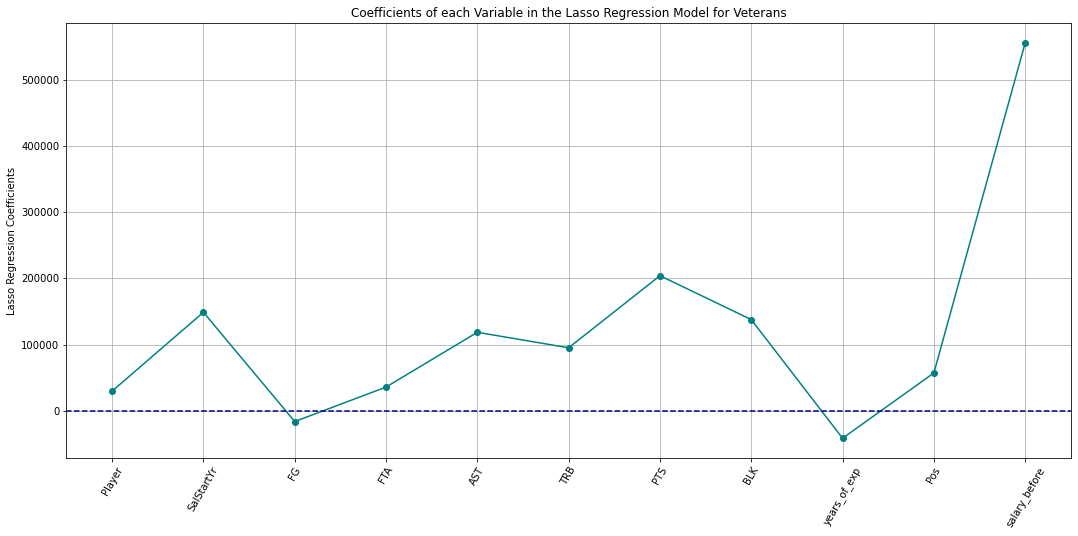

In [143]:
# Plot of Coefficients of Each Variable in the Lasso Regression Model for Veterans

plt.figure(figsize=(18, 8))
plt.plot(range(len(X.columns)), reg_best.coef_, 'bo-', color = "teal")
plt.axhline(y = 0, color = 'navy', linestyle='dashed')
plt.xticks(range(len(X.columns)), X.columns, rotation = 60)
plt.ylabel("Lasso Regression Coefficients")
plt.title("Coefficients of each Variable in the Lasso Regression Model for Veterans")
plt.grid()
plt.show()

## Final Results

**Overall:** R^2 = 0.59326, RMSE = 3067946.81366

**Cluster 0:** R^2 = 0.20333, RMSE = 1526392.85575

**Cluster 1:** R^2 = 0.17428, RMSE = 1092722.81674

**Cluster 2:** R^2 = 0.18218, RMSE = 2340873.13229